https://www.datacamp.com/community/tutorials/xgboost-in-python

In [1]:
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'
os.environ["PATH"] += os.pathsep + 'D:/LatexPackage/miktex/bin/x64'

In [2]:
os.environ["PATH"] += os.pathsep + 'D:/Database/Bitfinex-historical-data-master/Bitfinex-historical-data-master'

In [3]:
import warnings
warnings.filterwarnings("ignore")


In [4]:
from sklearn.datasets import load_boston

In [5]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error

In [6]:
import numpy as np

import matplotlib.pyplot as plt

import datetime as dt

from datetime import datetime

import pandas as pd
import urllib.request
     

from IPython.display import clear_output

In [7]:
## Loading BTC and XRP Data

In [8]:
header_format = ['timestamp_UTC_millisec',
'open_price',
'close_price',
'highest_price',
'lowest_price',
'volume']

In [21]:
BTC_USD_1min_path = 'D:\Database\Bitfinex-historical-data-master_backup\Bitfinex-historical-data-master\BTCUSD\Candles_1m'

In [22]:
BTC_2019 = pd.read_csv(BTC_USD_1min_path + '/2019/merged.csv', header=None ,names =  ['btc_' + d for d in header_format])

In [23]:
BTC_2018 = pd.read_csv(BTC_USD_1min_path + '/2018/merged.csv', header=None ,names =  ['btc_' + d for d in header_format])

In [24]:
XRP_USD_1min_path = 'D:\Database\Bitfinex-historical-data-master_backup\Bitfinex-historical-data-master\XRPUSD\Candles_1m'

In [25]:
XRP_2018 = pd.read_csv(XRP_USD_1min_path + '/2018/merged.csv', header=None, names = ['xrp_' + d for d in header_format])

In [26]:
XRP_2019 = pd.read_csv(XRP_USD_1min_path + '/2019/merged.csv', header=None , names =  ['xrp_' + d for d in header_format])

In [27]:
btc_xrp_merged_2019 = BTC_2019.merge(XRP_2019, 
               left_on = 'btc_timestamp_UTC_millisec', 
               right_on = 'xrp_timestamp_UTC_millisec', 
               how = 'outer')

In [28]:
btc_xrp_merged_2019['time_stamp_UTC_millisec'] = btc_xrp_merged_2019['xrp_timestamp_UTC_millisec']

In [29]:
btc_xrp_merged_2019['time_stamp_UTC_millisec'] = btc_xrp_merged_2019['time_stamp_UTC_millisec'].fillna(btc_xrp_merged_2019['btc_timestamp_UTC_millisec'])

In [35]:
btc_xrp_merged_2019.tail()

,btc_timestamp_UTC_millisec,btc_open_price,btc_close_price,btc_highest_price,btc_lowest_price,btc_volume,xrp_timestamp_UTC_millisec,xrp_open_price,xrp_close_price,xrp_highest_price,xrp_lowest_price,xrp_volume,time_stamp_UTC_millisec
435091,NaN,NaN,NaN,NaN,NaN,NaN,1.572598e+12,0.29248,0.29254,0.29254,0.29243,35279.507174,1.572598e+12
435092,NaN,NaN,NaN,NaN,NaN,NaN,1.572601e+12,0.29166,0.29165,0.29166,0.29165,388.265000,1.572601e+12
435093,NaN,NaN,NaN,NaN,NaN,NaN,1.572601e+12,0.29189,0.29189,0.29189,0.29183,2000.000000,1.572601e+12
435094,NaN,NaN,NaN,NaN,NaN,NaN,1.572603e+12,0.29201,0.29201,0.29201,0.29201,100.000000,1.572603e+12
435095,NaN,NaN,NaN,NaN,NaN,NaN,1.572605e+12,0.29211,0.29211,0.29211,0.29211,834.642329,1.572605e+12


# Starting of analysis

### Get 1min XRP data

In [36]:
XRP_USD_1min_path = 'D:\Database\Bitfinex-historical-data-master_backup\Bitfinex-historical-data-master\XRPUSD\Candles_1m'

In [37]:
header_format = ['timestamp_UTC_millisec',
'open_price',
'close_price',
'highest_price',
'lowest_price',
'volume']

In [38]:
xrp_2018_full = pd.read_csv(XRP_USD_1min_path + '/2018/merged.csv', header=None)

In [39]:
xrp_2019_until_Oct = pd.read_csv(XRP_USD_1min_path + '/2019/merged.csv', header=None)

In [40]:
xrp_2018_full.columns = header_format

In [41]:
xrp_2019_until_Oct.columns = header_format

In [42]:
xrp_2018_onwards = pd.concat([xrp_2018_full, xrp_2019_until_Oct])

In [43]:
XRP_Data = xrp_2018_onwards[xrp_2018_onwards['timestamp_UTC_millisec'] >= 1534287600000]

In [44]:
XRP_Data['datetime_real'] = XRP_Data['timestamp_UTC_millisec'].apply(lambda x: datetime.utcfromtimestamp(x/1000))

In [45]:
len(XRP_Data)

564561

In [46]:
XRP_Data['datetime_real'].min()

Timestamp('2018-08-14 23:00:00')

In [47]:
XRP_Data['datetime_real'].max()

Timestamp('2019-11-01 15:59:00')

In [48]:
(XRP_Data['datetime_real'].max() - XRP_Data['datetime_real'].min())

Timedelta('443 days 16:59:00')

In [49]:
XRP_Data['checking_timestamp_UTC_millisec'] = XRP_Data['timestamp_UTC_millisec'].shift(-1)

In [50]:
XRP_Data['dif'] = XRP_Data['checking_timestamp_UTC_millisec'] - XRP_Data['timestamp_UTC_millisec']

In [51]:
XRP_Data_resample_1min_ffill = XRP_Data.set_index('datetime_real').resample('1T').ffill()

In [52]:
XRP_Data_resample_1min_ffill['checking_timestamp_UTC_millisec'] = XRP_Data_resample_1min_ffill['timestamp_UTC_millisec'].shift(-1)

In [53]:
XRP_Data_resample_1min_ffill['dif'] = XRP_Data_resample_1min_ffill['checking_timestamp_UTC_millisec'] - XRP_Data_resample_1min_ffill['timestamp_UTC_millisec']

In [54]:
XRP_Data_resample_1min_ffill['timestamp_UTC'] = XRP_Data_resample_1min_ffill['timestamp_UTC_millisec']/1000

In [55]:
XRP_Data_resample_1min_ffill.head()

,timestamp_UTC_millisec,open_price,close_price,highest_price,lowest_price,volume,checking_timestamp_UTC_millisec,dif,timestamp_UTC
datetime_real,,,,,,,,,
2018-08-14 23:00:00,1534287600000,0.26444,0.26427,0.26448,0.26427,21493.134691,1.534288e+12,60000.0,1.534288e+09
2018-08-14 23:01:00,1534287660000,0.26410,0.26408,0.26418,0.26408,6316.950507,1.534288e+12,60000.0,1.534288e+09
2018-08-14 23:02:00,1534287720000,0.26419,0.26429,0.26429,0.26390,15876.859198,1.534288e+12,60000.0,1.534288e+09
2018-08-14 23:03:00,1534287780000,0.26389,0.26359,0.26389,0.26359,15102.000000,1.534288e+12,60000.0,1.534288e+09
2018-08-14 23:04:00,1534287840000,0.26368,0.26359,0.26379,0.26359,6305.473357,1.534288e+12,60000.0,1.534288e+09


#### rough check on data

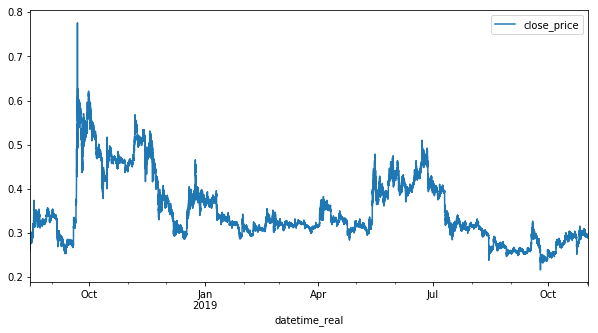

In [56]:
XRP_Data_resample_1min_ffill[['close_price']].plot(figsize = (10,5))

In [57]:
XRP_Data_resample_1min_ffill.tail(10)

,timestamp_UTC_millisec,open_price,close_price,highest_price,lowest_price,volume,checking_timestamp_UTC_millisec,dif,timestamp_UTC
datetime_real,,,,,,,,,
2019-11-01 15:50:00,1572623400000,0.29032,0.29029,0.29032,0.29029,18977.229740,1.572623e+12,60000.0,1.572623e+09
2019-11-01 15:51:00,1572623460000,0.29034,0.29030,0.29035,0.29030,11583.433064,1.572624e+12,60000.0,1.572623e+09
2019-11-01 15:52:00,1572623520000,0.29070,0.29046,0.29071,0.29046,205.000000,1.572624e+12,60000.0,1.572624e+09
2019-11-01 15:53:00,1572623580000,0.29058,0.29077,0.29077,0.29046,20164.038042,1.572624e+12,0.0,1.572624e+09
2019-11-01 15:54:00,1572623580000,0.29058,0.29077,0.29077,0.29046,20164.038042,1.572624e+12,120000.0,1.572624e+09
2019-11-01 15:55:00,1572623700000,0.29083,0.29173,0.29173,0.29083,1570.393827,1.572624e+12,60000.0,1.572624e+09
2019-11-01 15:56:00,1572623760000,0.29161,0.29150,0.29161,0.29120,4022.034331,1.572624e+12,60000.0,1.572624e+09
2019-11-01 15:57:00,1572623820000,0.29180,0.29154,0.29207,0.29154,6854.915950,1.572624e+12,60000.0,1.572624e+09
2019-11-01 15:58:00,1572623880000,0.29139,0.29030,0.29151,0.29030,8296.541362,1.572624e+12,60000.0,1.572624e+09



 selecting '2018-08-15 00:00:00' as the starting time as it bypasses the past crypto rush


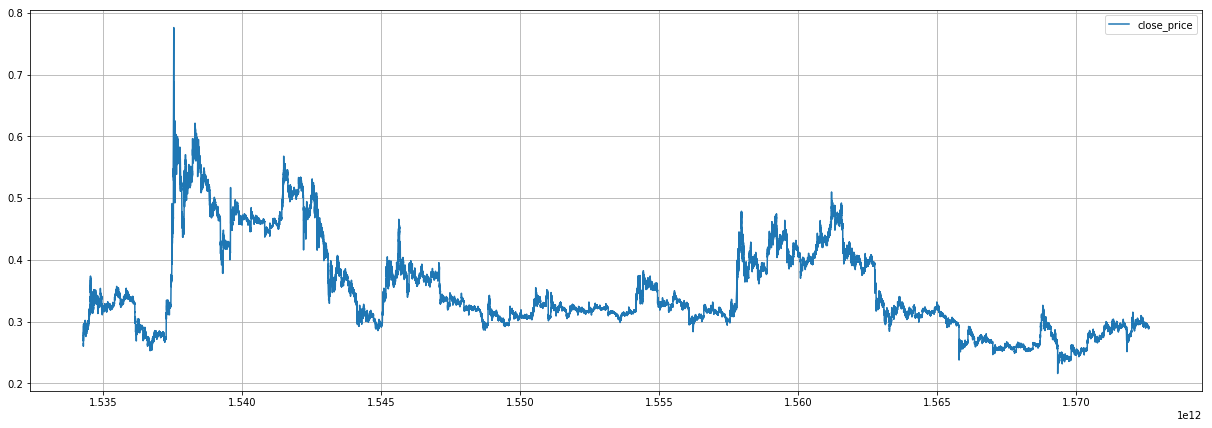

In [58]:
ploting_breakdown = XRP_Data_resample_1min_ffill.reset_index()

plt.figure(figsize= (21,7))


# tran_y_low = ploting_breakdown['low']
# tran_y_high = ploting_breakdown['high']
tran_y_close = ploting_breakdown['close_price']

tran_x = ploting_breakdown['timestamp_UTC_millisec']


# plt.plot(tran_x, tran_y_low, alpha = 0.1)
# plt.plot(tran_x, tran_y_high , alpha  = 0.1)

plt.plot(tran_x, tran_y_close, alpha  = 1)


# start = 45000
# dealta_t = 10000
time_section = {45000 : 13000,
                63000 : 8000 ,
                71000 : 10000,
                180000: 10000}  # start // delta_t



# plt.vlines(1534287600000, 0, 1, alpha = 1, color = 'g',linestyle = 'dashed')
    
plt.legend()
plt.grid()
print("\n selecting '2018-08-15 00:00:00' as the starting time as it bypasses the past crypto rush")

In [59]:
ploting_breakdown[ploting_breakdown['datetime_real'] == '2018-08-15 00:00:00']

,datetime_real,timestamp_UTC_millisec,open_price,close_price,highest_price,lowest_price,volume,checking_timestamp_UTC_millisec,dif,timestamp_UTC
60,2018-08-15,1534291200000,0.27279,0.2734,0.27349,0.27279,17252.63782,1.534291e+12,60000.0,1.534291e+09


In [60]:
ploting_breakdown[ploting_breakdown['datetime_real'] == '2019-08-15 00:00:00']

,datetime_real,timestamp_UTC_millisec,open_price,close_price,highest_price,lowest_price,volume,checking_timestamp_UTC_millisec,dif,timestamp_UTC
525660,2019-08-15,1565827200000,0.26373,0.26559,0.26559,0.26363,166192.961293,1.565827e+12,60000.0,1.565827e+09


## Saving Data 

In [63]:
# XRP_Data_backUp = XRP_Data_resample_1min_ffill.copy()

## Copy for testing

In [64]:
XRP_for_training =XRP_Data_resample_1min_ffill[(XRP_Data_resample_1min_ffill['timestamp_UTC'] >= 1534287600) &
                           (XRP_Data_resample_1min_ffill['timestamp_UTC'] <1565823600)].reset_index().copy()

In [65]:
XRP_for_testing =XRP_Data_resample_1min_ffill[(XRP_Data_resample_1min_ffill['timestamp_UTC'] >= 1565823600)].reset_index().copy()

In [66]:
XRP_for_testing.head()

,datetime_real,timestamp_UTC_millisec,open_price,close_price,highest_price,lowest_price,volume,checking_timestamp_UTC_millisec,dif,timestamp_UTC
0,2019-08-14 23:00:00,1565823600000,0.27050,0.27034,0.27050,0.27032,200.000000,1.565824e+12,60000.0,1.565824e+09
1,2019-08-14 23:01:00,1565823660000,0.27034,0.27014,0.27034,0.27011,6970.610576,1.565824e+12,60000.0,1.565824e+09
2,2019-08-14 23:02:00,1565823720000,0.27015,0.27031,0.27044,0.27015,9002.533511,1.565824e+12,60000.0,1.565824e+09
3,2019-08-14 23:03:00,1565823780000,0.27028,0.27028,0.27034,0.27027,22726.951973,1.565824e+12,60000.0,1.565824e+09
4,2019-08-14 23:04:00,1565823840000,0.27015,0.26971,0.27015,0.26932,115833.923778,1.565824e+12,60000.0,1.565824e+09


In [67]:
XRP_for_testing['datetime_real'].max()

Timestamp('2019-11-01 15:59:00')

In [68]:
XRP_for_testing['datetime_real'].min()

Timestamp('2019-08-14 23:00:00')

## Analysis on training datasets

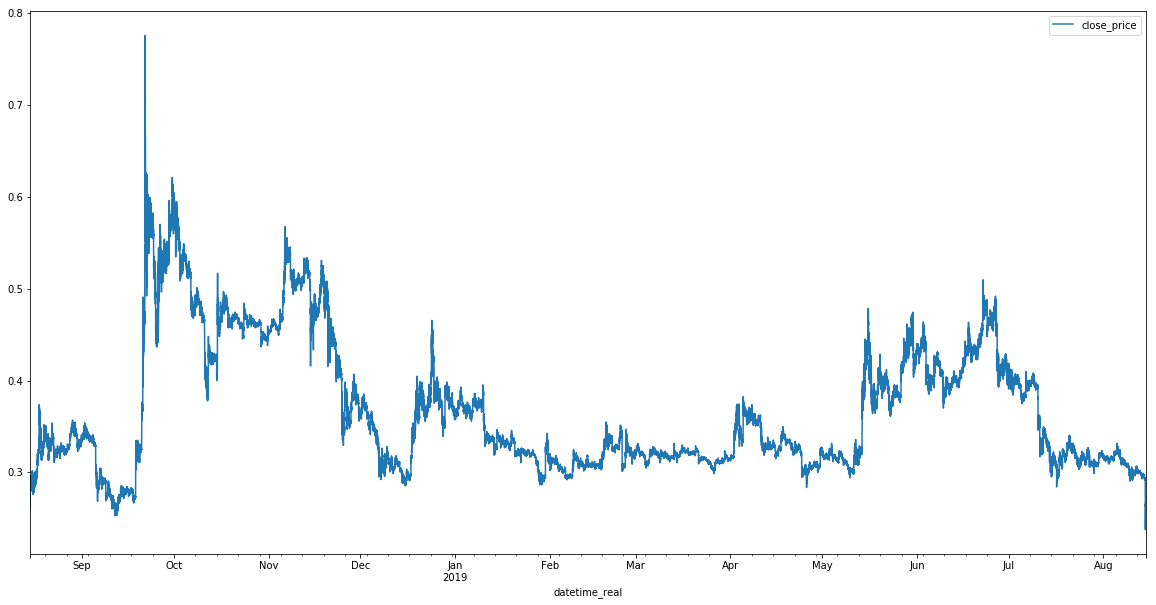

In [69]:
XRP_for_training.set_index('datetime_real')[['close_price']].plot(figsize = (20,10))

## Data mining, making own properties and features

In [70]:
section_period = {  '3min': 3,
                    '4min': 4,
                    '5min': 5,
                    '10min': 10,
                    '15min': 15,
                    '20min': 20,
                    '25min': 25,
                    '30min': 30,
                    '35min': 35,
                    '40min': 40,
                    '45min': 45,
                    '50min': 50,
                    '55min': 55,
                    '1H': 60,
                    '2H': 120,
                    '3H': 180,
                    '4H': 240,
                    '5H': 300,
                    '6H': 360,
                    '7H': 420,
                    '8H': 480,
                    '9H': 540,
                    '10H': 600,
                    '11H': 660,
                    '12H': 720,
                    '24H': 1440,
                    '2D': 2880,
                    '3D': 4320,
                    '4D': 5760,
                    '5D': 7200,
                    '10D': 14400}

In [71]:
for k,v in section_period.items():
    XRP_for_training['{0}_RA_on_Close'.format(k)] = XRP_for_training['close_price'].rolling(v).mean()

In [72]:
compare_sequence = {}

In [73]:
for col_1 in [d for d in XRP_for_training.columns if '_RA_on_Close' in d]:
    for col_2 in [d for d in XRP_for_training.columns if '_RA_on_Close' in d]:
        temp_1 = col_1.split('_RA_on_Close')[0]
        temp_2 = col_2.split('_RA_on_Close')[0]
        if temp_1 != temp_2:
            if ((temp_1 + '_minus_' + temp_2) not in compare_sequence.keys() and (temp_2 + '_minus_' + temp_1) not in compare_sequence.keys() ):
                compare_sequence.update({temp_1 + '_minus_' + temp_2 : [col_1, col_2]})

In [74]:
for k, val in compare_sequence.items():
    XRP_for_training[k] = (XRP_for_training[val[0]] - XRP_for_training[val[1]])/XRP_for_training[val[1]] 
#     print(k, val[0], val[1])

In [75]:
for col in [d for d in XRP_for_training.columns if '_RA_on_Close' in d]:
    XRP_for_training[col] = XRP_for_training[col].shift(1)
    
    XRP_for_training['{0}_close_percent_dif'.format(col.split('_RA_on_Close')[0])] = (XRP_for_training['close_price']-XRP_for_training[col])/XRP_for_training[col] 

In [76]:
for k,v in section_period.items():
    print(k,v)
    XRP_for_training['look_back_{}'.format(k)] = XRP_for_training['close_price'].shift(v)   # i.e. 20min ago, this is what the close price is
    XRP_for_training['look_forward_{}'.format(k)] = XRP_for_training['close_price'].shift(-v)  # i.e. 20min later, the close price is


for k,v in section_period.items():
    print(k,v)
    XRP_for_training['calculate_look_back_Percent_{}'.format(k)]    = 100*(XRP_for_training['close_price'] - XRP_for_training['look_back_{}'.format(k)])/(v)
    XRP_for_training['calculate_look_forward_Percent_{}'.format(k)] =  100*(XRP_for_training['look_forward_{}'.format(k)] - XRP_for_training['close_price'])/(v)

3min 3
4min 4
5min 5
10min 10
15min 15
20min 20
25min 25
30min 30
35min 35
40min 40
45min 45
50min 50
55min 55
1H 60
2H 120
3H 180
4H 240
5H 300
6H 360
7H 420
8H 480
9H 540
10H 600
11H 660
12H 720
24H 1440
2D 2880
3D 4320
4D 5760
5D 7200
10D 14400
3min 3
4min 4
5min 5
10min 10
15min 15
20min 20
25min 25
30min 30
35min 35
40min 40
45min 45
50min 50
55min 55
1H 60
2H 120
3H 180
4H 240
5H 300
6H 360
7H 420
8H 480
9H 540
10H 600
11H 660
12H 720
24H 1440
2D 2880
3D 4320
4D 5760
5D 7200
10D 14400


net_{net_percent}_percent is the net_percent + minimum for profit, 

i.e. net_01_percent = 0.1% + 0.003 = 0.004

In [77]:
net_01_percent = 0.004
net_02_percent = 0.007  # (for x percent, percent wrong needs to be taken into consideration)

In [78]:
look_forward_time_condition = ['calculate_look_forward_Percent_3min',
 'calculate_look_forward_Percent_4min',
 'calculate_look_forward_Percent_5min',
 'calculate_look_forward_Percent_10min',
 'calculate_look_forward_Percent_15min',
 'calculate_look_forward_Percent_20min',
 'calculate_look_forward_Percent_25min',
 'calculate_look_forward_Percent_30min',
 'calculate_look_forward_Percent_35min',
 'calculate_look_forward_Percent_40min',
 'calculate_look_forward_Percent_45min',
 'calculate_look_forward_Percent_50min',
 'calculate_look_forward_Percent_55min',
 'calculate_look_forward_Percent_1H',
 'calculate_look_forward_Percent_2H',
 'calculate_look_forward_Percent_3H',
 'calculate_look_forward_Percent_4H',
 'calculate_look_forward_Percent_5H',
 'calculate_look_forward_Percent_6H']

In [79]:
# Buy_in_decision = pd.DataFrame((XRP_for_training[['timestamp_UTC'] + [d for d in XRP_for_training.columns if '_forward_Percent_' in d]].set_index('timestamp_UTC') > net_02_percent).any(axis =1 )).rename(columns ={0: 'Buy_In'})
Buy_in_decision = pd.DataFrame((XRP_for_training[['timestamp_UTC'] + look_forward_time_condition].set_index('timestamp_UTC') > net_02_percent).any(axis =1 )).rename(columns ={0: 'Buy_In'})

In [80]:
within_target_02_profit = XRP_for_training.merge(Buy_in_decision.reset_index(), on ='timestamp_UTC', how='left').dropna()

In [81]:
within_target_02_profit.head()

,datetime_real,timestamp_UTC_millisec,open_price,close_price,highest_price,lowest_price,volume,checking_timestamp_UTC_millisec,dif,timestamp_UTC,...,calculate_look_forward_Percent_2D,calculate_look_back_Percent_3D,calculate_look_forward_Percent_3D,calculate_look_back_Percent_4D,calculate_look_forward_Percent_4D,calculate_look_back_Percent_5D,calculate_look_forward_Percent_5D,calculate_look_back_Percent_10D,calculate_look_forward_Percent_10D,Buy_In
16574,2018-08-24 23:00:00,1535151600000,0.32687,0.32709,0.32742,0.32687,32028.654097,1.535152e+12,60000.0,1.535152e+09,...,-0.000184,-0.000172,0.000133,0.000109,0.000440,-0.000248,0.000271,0.000436,0.000056,False
16575,2018-08-24 23:01:00,1535151660000,0.32709,0.32698,0.32709,0.32698,9644.315221,1.535152e+12,60000.0,1.535152e+09,...,-0.000180,-0.000185,0.000138,0.000137,0.000441,-0.000253,0.000274,0.000437,0.000056,False
16576,2018-08-24 23:02:00,1535151720000,0.32699,0.32691,0.32699,0.32691,14352.199593,1.535152e+12,60000.0,1.535152e+09,...,-0.000177,-0.000187,0.000123,0.000132,0.000441,-0.000254,0.000274,0.000435,0.000056,False
16577,2018-08-24 23:03:00,1535151780000,0.32691,0.32630,0.32691,0.32630,30312.173041,1.535152e+12,60000.0,1.535152e+09,...,-0.000156,-0.000194,0.000137,0.000159,0.000451,-0.000252,0.000283,0.000435,0.000060,True
16578,2018-08-24 23:04:00,1535151840000,0.32630,0.32616,0.32630,0.32616,6672.409474,1.535152e+12,60000.0,1.535152e+09,...,-0.000151,-0.000207,0.000140,0.000178,0.000443,-0.000254,0.000285,0.000435,0.000064,True


In [82]:
XRP_for_testing['datetime_real'].max()

Timestamp('2019-11-01 15:59:00')

In [83]:
within_target_02_profit['datetime_real'].min()

Timestamp('2018-08-24 23:00:00')

#### Selecting properties and becareful not to have any properties that look forward

In [84]:
properties = [
#     'close',
#  'date',
#  'high',
#  'low',
#  'open',
#  'quoteVolume',
 'volume',
#  'weightedAverage',
#  'datetime_real',
 '3min_close_percent_dif',
 '4min_close_percent_dif',
 '5min_close_percent_dif',
 '10min_close_percent_dif',
 '15min_close_percent_dif',
 '20min_close_percent_dif',
 '1H_close_percent_dif',
 '2H_close_percent_dif',
 '4H_close_percent_dif',
 '12H_close_percent_dif',
 '24H_close_percent_dif',
 '2D_close_percent_dif',
 '3D_close_percent_dif',
 '4D_close_percent_dif',
 '5D_close_percent_dif',
 '10D_close_percent_dif',
 'calculate_look_back_Percent_3min',
 'calculate_look_back_Percent_4min',
 'calculate_look_back_Percent_5min',
 'calculate_look_back_Percent_10min',
 'calculate_look_back_Percent_15min',
 'calculate_look_back_Percent_20min',
 'calculate_look_back_Percent_1H',
 'calculate_look_back_Percent_2H',
 'calculate_look_back_Percent_4H',
 'calculate_look_back_Percent_12H',
 'calculate_look_back_Percent_24H',
 'calculate_look_back_Percent_2D',
 'calculate_look_back_Percent_3D',
 'calculate_look_back_Percent_4D',
 'calculate_look_back_Percent_5D',
 'calculate_look_back_Percent_10D',
 '3min_minus_4min',
 '3min_minus_5min',
 '3min_minus_10min',
 '3min_minus_15min',
 '3min_minus_20min',
 '3min_minus_1H',
 '3min_minus_2H',
 '3min_minus_4H',
 '3min_minus_12H',
 '3min_minus_24H',
 '3min_minus_2D',
 '3min_minus_3D',
 '3min_minus_4D',
 '3min_minus_5D',
 '3min_minus_10D',
 '4min_minus_5min',
 '4min_minus_10min',
 '4min_minus_15min',
 '4min_minus_20min',
 '4min_minus_1H',
 '4min_minus_2H',
 '4min_minus_4H',
 '4min_minus_12H',
 '4min_minus_24H',
 '4min_minus_2D',
 '4min_minus_3D',
 '4min_minus_4D',
 '4min_minus_5D',
 '4min_minus_10D',
 '5min_minus_10min',
 '5min_minus_15min',
 '5min_minus_20min',
 '5min_minus_1H',
 '5min_minus_2H',
 '5min_minus_4H',
 '5min_minus_12H',
 '5min_minus_24H',
 '5min_minus_2D',
 '5min_minus_3D',
 '5min_minus_4D',
 '5min_minus_5D',
 '5min_minus_10D',
 '10min_minus_15min',
 '10min_minus_20min',
 '10min_minus_1H',
 '10min_minus_2H',
 '10min_minus_4H',
 '10min_minus_12H',
 '10min_minus_24H',
 '10min_minus_2D',
 '10min_minus_3D',
 '10min_minus_4D',
 '10min_minus_5D',
 '10min_minus_10D',
 '15min_minus_20min',
 '15min_minus_1H',
 '15min_minus_2H',
 '15min_minus_4H',
 '15min_minus_12H',
 '15min_minus_24H',
 '15min_minus_2D',
 '15min_minus_3D',
 '15min_minus_4D',
 '15min_minus_5D',
 '15min_minus_10D',
 '20min_minus_1H',
 '20min_minus_2H',
 '20min_minus_4H',
 '20min_minus_12H',
 '20min_minus_24H',
 '20min_minus_2D',
 '20min_minus_3D',
 '20min_minus_4D',
 '20min_minus_5D',
 '20min_minus_10D',
 '1H_minus_2H',
 '1H_minus_4H',
 '1H_minus_12H',
 '1H_minus_24H',
 '1H_minus_2D',
 '1H_minus_3D',
 '1H_minus_4D',
 '1H_minus_5D',
 '1H_minus_10D',
 '2H_minus_4H',
 '2H_minus_12H',
 '2H_minus_24H',
 '2H_minus_2D',
 '2H_minus_3D',
 '2H_minus_4D',
 '2H_minus_5D',
 '2H_minus_10D',
 '4H_minus_12H',
 '4H_minus_24H',
 '4H_minus_2D',
 '4H_minus_3D',
 '4H_minus_4D',
 '4H_minus_5D',
 '4H_minus_10D',
 '12H_minus_24H',
 '12H_minus_2D',
 '12H_minus_3D',
 '12H_minus_4D',
 '12H_minus_5D',
 '12H_minus_10D',
 '24H_minus_2D',
 '24H_minus_3D',
 '24H_minus_4D',
 '24H_minus_5D',
 '24H_minus_10D',
 '2D_minus_3D',
 '2D_minus_4D',
 '2D_minus_5D',
 '2D_minus_10D',
 '3D_minus_4D',
 '3D_minus_5D',
 '3D_minus_10D',
 '4D_minus_5D',
 '4D_minus_10D',
 '5D_minus_10D']

## split into target and properties

In [85]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier

In [86]:
from sklearn.externals.six import StringIO  
from IPython.display import Image
from sklearn.tree import export_graphviz
import pydotplus

import pydot

In [87]:
from collections import Counter

In [88]:
import math

In [152]:
within_target_02_profit['datetime_real'].max()

Timestamp('2019-08-04 22:59:00')

In [206]:
target_y = within_target_02_profit[['Buy_In']].copy()

In [207]:
# train_x = within_target_02_profit[properties].copy()
# train_x = within_target_02_profit[iterate_1_features].copy()
train_x = within_target_02_profit[iterate_2_features].copy()


In [208]:
target_y.columns

Index(['Buy_In'], dtype='object')

In [209]:
# X_train, X_test, y_train, y_test = train_test_split(train_x, target_y, test_size=0.33, random_state=324)

In [210]:
X_train_order = train_x.iloc[:-math.floor(len(train_x)*0.2)]

In [211]:
y_train_order = target_y.iloc[:-math.floor(len(target_y)*0.2)]

In [212]:
X_test_order = train_x.iloc[-math.floor(len(train_x)*0.2):]

In [213]:
y_test_order = target_y.iloc[-math.floor(len(target_y)*0.2):]

## Logistical Regression

In [232]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

In [233]:
prob_logistical_training= LogisticRegression()


In [234]:
prob_logistical_training.fit(X_train_order, y_train_order)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [235]:
y_pred = prob_logistical_training.predict(X_test_order)


ValueError: setting an array element with a sequence.

In [ ]:
confusion_matrix(y_test_order, y_pred)

In [ ]:
accuracy_score(y_true = y_test_order, y_pred = y_pred)

In [ ]:
prodicted_probs = prob_logistical_training.predict_proba(X_test_order)

In [ ]:
X_test_order['predict_prob'] = [(d[0], d[1]) for d in prodicted_probs]

In [ ]:
X_test_order['actual'] = y_test_order

In [ ]:
X_test_order['predict'] = y_pred

In [ ]:
X_test_order['negative_buy_in'] = [d[0] for d in X_test_order['predict_prob']]

In [ ]:
X_test_order['positive_buy_in'] = [d[1] for d in X_test_order['predict_prob']]

## XG Boost

In [255]:
#X, y = data.iloc[:,:-1],data.iloc[:,-1]

In [256]:
# X, y = within_target_02_profit[properties].copy(), within_target_02_profit['Buy_In'].copy()
# X, y = within_target_02_profit[iterate_1_features].copy(), within_target_02_profit['Buy_In'].copy()
X, y = within_target_02_profit[iterate_2_features].copy(), within_target_02_profit['Buy_In'].copy()

In [257]:
data_dmatrix = xgb.DMatrix(data=X,label=y)

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [258]:
X_train_order = X.iloc[:-math.floor(len(X)*0.2)]

In [259]:
y_train_order = y.iloc[:-math.floor(len(y)*0.2)]

In [260]:
X_test_order = X.iloc[-math.floor(len(X)*0.2):]

In [261]:
y_test_order = y.iloc[-math.floor(len(y)*0.2):]

In [262]:
# plot decision tree
# from numpy import loadtxt
# from xgboost import XGBClassifier
from xgboost import plot_tree

# load data
# dataset = loadtxt('pima-indians-diabetes.csv', delimiter=",")
# split data into X and y
# X = dataset[:,0:8]
# y = dataset[:,8]
# # fit model no training data
# model = XGBClassifier()
# model.fit(X, y)
# plot single tree


In [263]:
xg_reg = xgb.XGBClassifier().fit(X = X_train_order, y = y_train_order ) #reg:logistic for tree


In [264]:
y_pred = xg_reg.predict(X_test_order)

In [265]:
xg_reg.predict_proba(X_test_order)

array([[0.666483  , 0.33351701],
       [0.666483  , 0.33351701],
       [0.666483  , 0.33351701],
       ...,
       [0.5086893 , 0.49131075],
       [0.5160893 , 0.48391068],
       [0.53310513, 0.46689484]], dtype=float32)

In [266]:
predict_prob = xg_reg.predict_proba(X_test_order)

In [267]:
accuracy = accuracy_score(y_true = y_test_order, y_pred = y_pred)

In [268]:
print(accuracy)  #0.6557448975170083

0.645079516401612


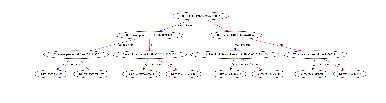

In [269]:
plot_tree(xg_reg)

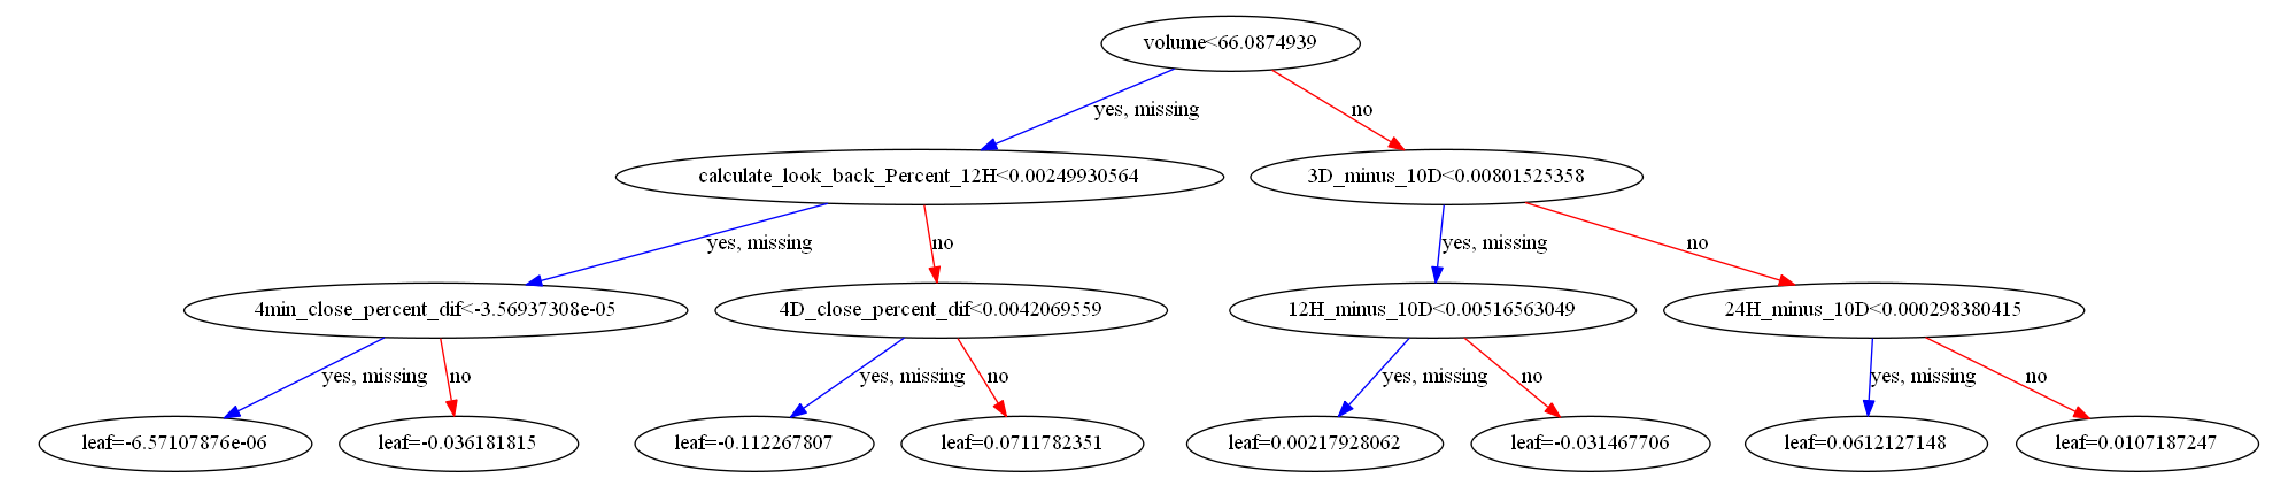

In [270]:
fig, ax = plt.subplots(figsize=(40, 60))
xgb.plot_tree(xg_reg, num_trees=30, ax=ax)
plt.show()

<BarContainer object of 26 artists>

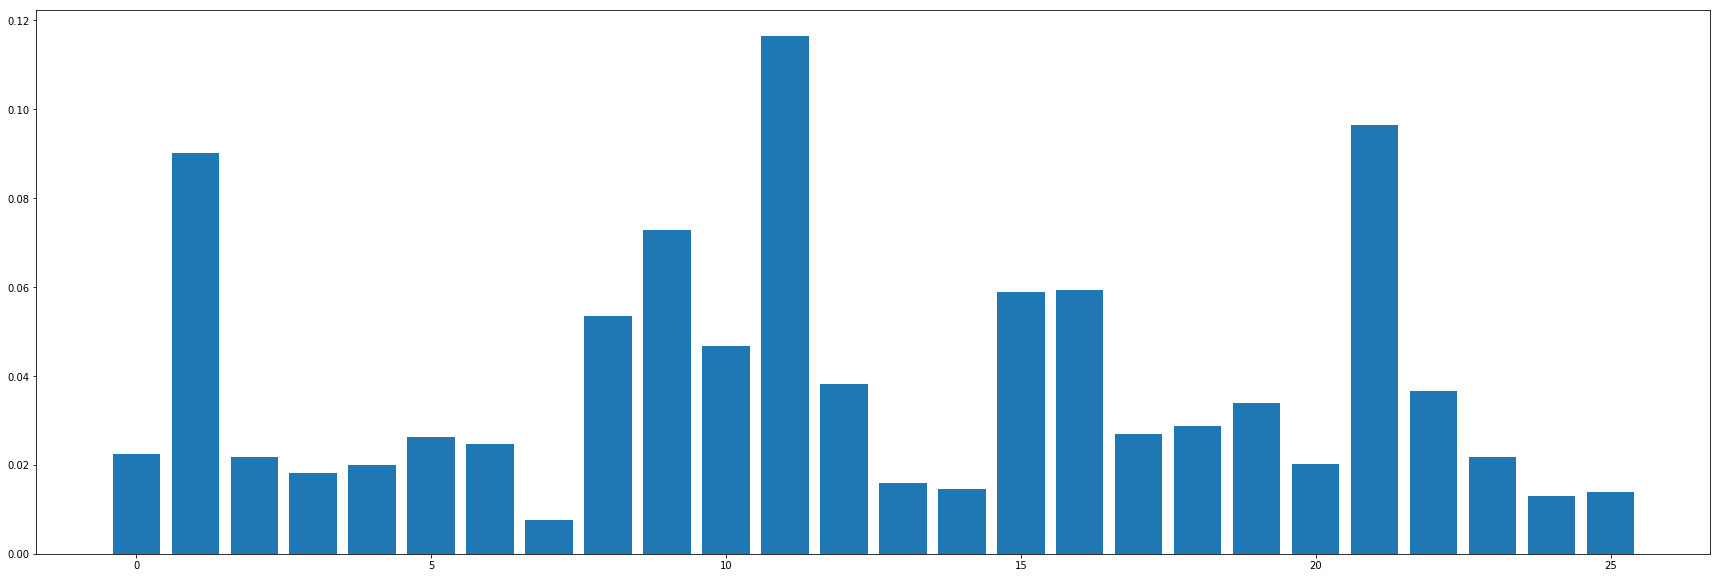

In [271]:
plt.figure(figsize=(30,10)).show()
plt.bar(range(len(xg_reg.feature_importances_)), xg_reg.feature_importances_ )


In [250]:
X_train_order.columns

Index(['volume', '3min_close_percent_dif', '4min_close_percent_dif',
       '20min_close_percent_dif', '24H_close_percent_dif',
       '3D_close_percent_dif', '4D_close_percent_dif',
       'calculate_look_back_Percent_3min', 'calculate_look_back_Percent_4min',
       'calculate_look_back_Percent_5min', 'calculate_look_back_Percent_10min',
       'calculate_look_back_Percent_15min',
       'calculate_look_back_Percent_20min', 'calculate_look_back_Percent_1H',
       'calculate_look_back_Percent_4H', 'calculate_look_back_Percent_12H',
       'calculate_look_back_Percent_24H', 'calculate_look_back_Percent_2D',
       '3min_minus_4H', '3min_minus_24H', '4min_minus_5min',
       '4min_minus_15min', '5min_minus_24H', '10min_minus_15min',
       '15min_minus_20min', '1H_minus_10D', '2H_minus_24H', '4H_minus_10D',
       '12H_minus_3D', '12H_minus_10D', '24H_minus_10D', '2D_minus_10D',
       '3D_minus_5D', '3D_minus_10D'],
      dtype='object')

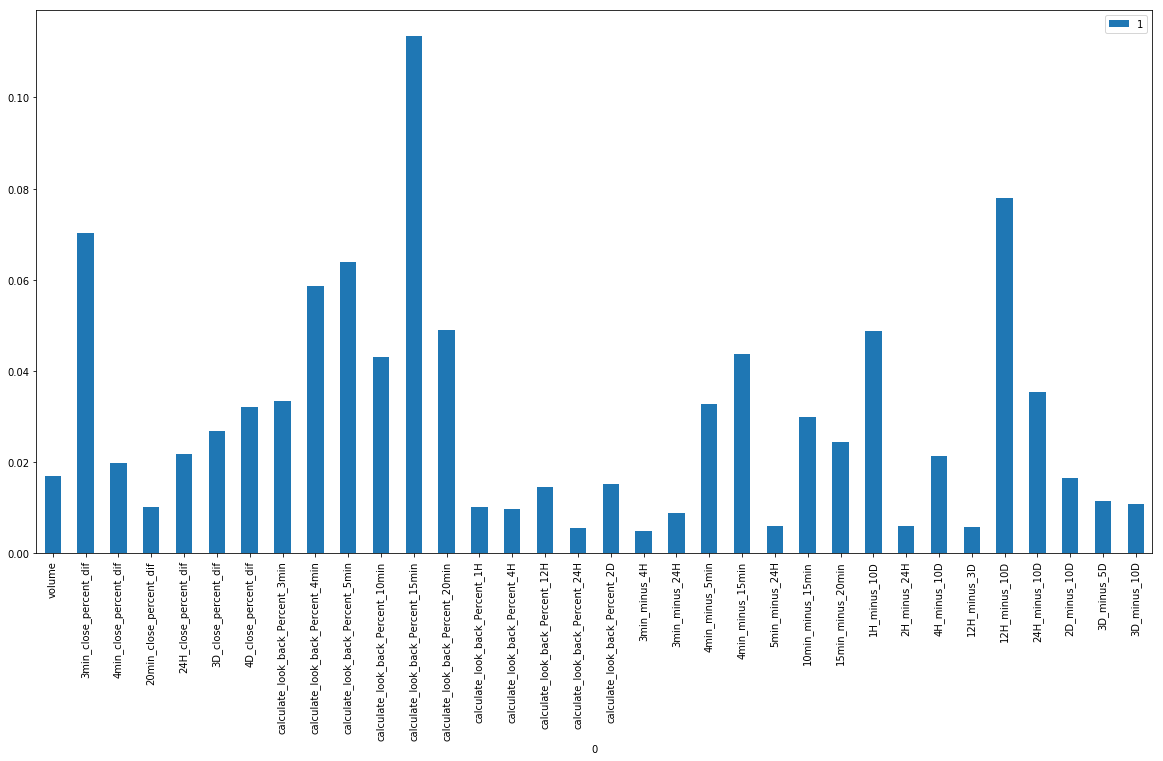

In [254]:
pd.DataFrame([X_train_order.columns, xg_reg.feature_importances_]).T.set_index(0).plot.bar(figsize = (20,10))

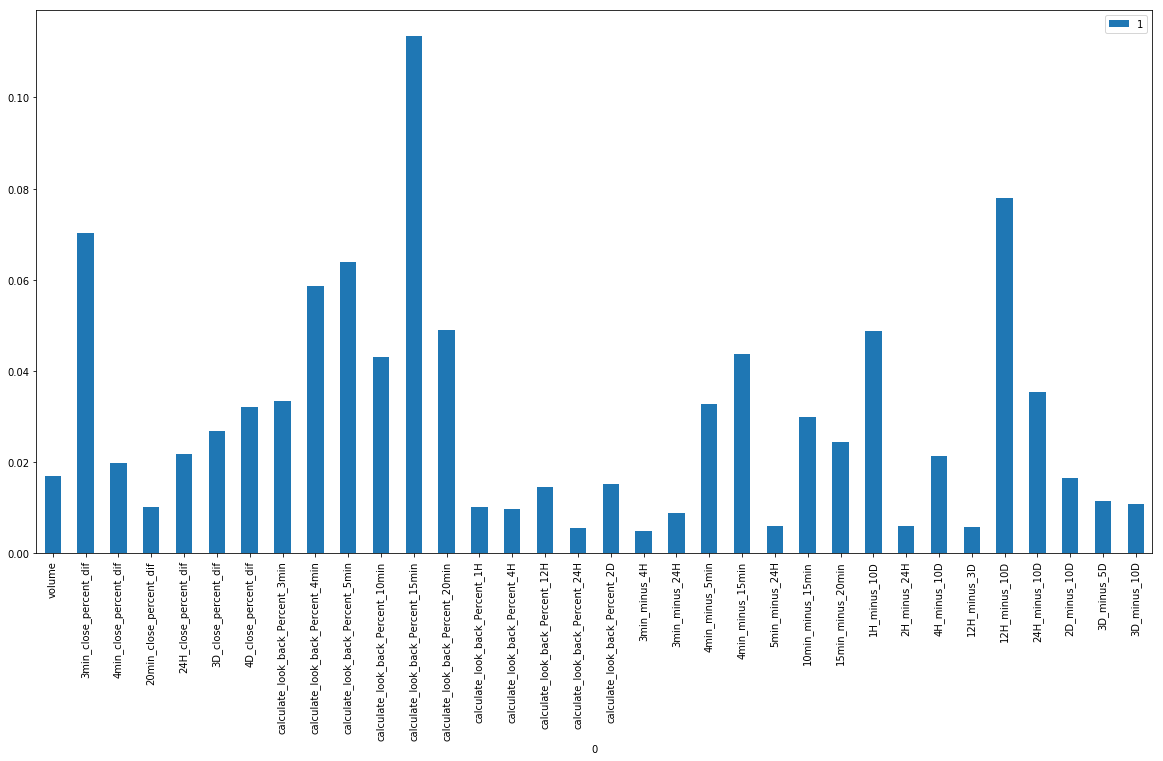

In [198]:
pd.DataFrame([X_train_order.columns, xg_reg.feature_importances_]).T.set_index(0).plot.bar(figsize = (20,10))

'calculate_look_back_Percent_1H',
'calculate_look_back_Percent_4H',
'calculate_look_back_Percent_24H',
'3min_minus_4H',
'3min_minus_24H',
'5min_minus_24H',
'2H_minus_24H',
'12H_minus_3D',

^--- void these features

In [195]:
features_observe = pd.DataFrame([X_train_order.columns, xg_reg.feature_importances_]).T

In [136]:
features_observe[2] = 0.005

In [145]:
# iterate_1_features  = features_observe[features_observe[1] > 0.005][0].values

In [202]:
# iterate_2_features  = [fe for fe in features_observe[0] if fe not in ['calculate_look_back_Percent_1H',
# 'calculate_look_back_Percent_4H',
# 'calculate_look_back_Percent_24H',
# '3min_minus_4H',
# '3min_minus_24H',
# '5min_minus_24H',
# '2H_minus_24H',
# '12H_minus_3D']]

### memory reduction

memory_X_to_train = X_train_order.iloc[:5,:5]

memory_y_to_train = y_train_order[:5]

memory_X_to_test = X_test_order.iloc[:5,:5]
memory_y_to_test = y_test_order[:5]

xg_reg.fit(memory_X_to_train, memory_y_to_train)

preds = xg_reg.predict(memory_X_to_test)

memory_y_to_test

preds

accu_sc = accuracy_score(y_true = memory_y_to_test, y_pred = preds)
print("RMSE: %f" % (accu_sc))

In [ ]:
## Decision Tree

buy_in_decision_classifier = DecisionTreeClassifier(max_leaf_nodes=10, random_state=0)
buy_in_decision_classifier.fit(X_train_order, y_train_order)

predictions = buy_in_decision_classifier.predict(X_test_order)

accuracy_score(y_true = y_test_order, y_pred = predictions)

for node in [2,3,4,5,6,8,10,12,15,20,25,30]:
    for state_rand in [0,1,42,235,1995]:
        buy_in_decision_classifier = DecisionTreeClassifier(max_leaf_nodes=node, random_state=state_rand)
        buy_in_decision_classifier.fit(X_train_order, y_train_order)

        predictions = buy_in_decision_classifier.predict(X_test_order)

        print('node' , node, 'accuracy', accuracy_score(y_true = y_test_order, y_pred = predictions) , 'sate' , state_rand) 



#1

node = 8
state_rand = 0  #,1,42,235,1995]:
buy_in_decision_classifier = DecisionTreeClassifier(max_leaf_nodes=node, random_state=state_rand)
buy_in_decision_classifier.fit(X_train_order, y_train_order)

predictions = buy_in_decision_classifier.predict(X_test_order)

print(accuracy_score(y_true = y_test_order, y_pred = predictions) , 'sate' , state_rand) 

In [ ]:
xg_reg.predict()

In [ ]:
Counter(predictions)

In [ ]:
Counter(y_test_order['Buy_In'])

In [ ]:
predictions

In [ ]:
dot_data = StringIO()
export_graphviz(buy_in_decision_classifier,
                feature_names=list(X_train_order.columns),
                out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True)

In [ ]:
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  

In [ ]:
graph.write_png("tree.png")


In [ ]:
Image(graph.create_png())

## Testing theory

In [156]:
XRP_for_testing.head()

,datetime_real,timestamp_UTC_millisec,open_price,close_price,highest_price,lowest_price,volume,checking_timestamp_UTC_millisec,dif,timestamp_UTC
0,2019-08-14 23:00:00,1565823600000,0.27050,0.27034,0.27050,0.27032,200.000000,1.565824e+12,60000.0,1.565824e+09
1,2019-08-14 23:01:00,1565823660000,0.27034,0.27014,0.27034,0.27011,6970.610576,1.565824e+12,60000.0,1.565824e+09
2,2019-08-14 23:02:00,1565823720000,0.27015,0.27031,0.27044,0.27015,9002.533511,1.565824e+12,60000.0,1.565824e+09
3,2019-08-14 23:03:00,1565823780000,0.27028,0.27028,0.27034,0.27027,22726.951973,1.565824e+12,60000.0,1.565824e+09
4,2019-08-14 23:04:00,1565823840000,0.27015,0.26971,0.27015,0.26932,115833.923778,1.565824e+12,60000.0,1.565824e+09


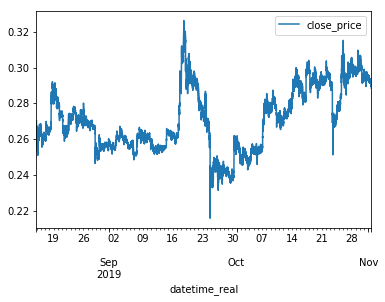

In [157]:
XRP_for_testing[['close_price','datetime_real']].set_index('datetime_real').plot()

In [158]:
section_period = {  '3min': 3,
                    '4min': 4,
                    '5min': 5,
                    '10min': 10,
                    '15min': 15,
                    '20min': 20,
                    '25min': 25,
                    '30min': 30,
                    '35min': 35,
                    '40min': 40,
                    '45min': 45,
                    '50min': 50,
                    '55min': 55,
                    '1H': 60,
                    '2H': 120,
                    '4H': 240,
                    '12H': 720,
                    '24H': 1440,
                    '2D': 2880,
                    '3D': 4320,
                    '4D': 5760,
                    '5D': 7200,
                    '10D': 14400}

In [159]:
for k,v in section_period.items():
    XRP_for_testing['{0}_RA_on_Close'.format(k)] = XRP_for_testing['close_price'].rolling(v).mean()

In [160]:
compare_sequence = {}

In [161]:
for col_1 in [d for d in XRP_for_testing.columns if '_RA_on_Close' in d]:
    for col_2 in [d for d in XRP_for_testing.columns if '_RA_on_Close' in d]:
        temp_1 = col_1.split('_RA_on_Close')[0]
        temp_2 = col_2.split('_RA_on_Close')[0]
        if temp_1 != temp_2:
            if ((temp_1 + '_minus_' + temp_2) not in compare_sequence.keys() and (temp_2 + '_minus_' + temp_1) not in compare_sequence.keys() ):
                compare_sequence.update({temp_1 + '_minus_' + temp_2 : [col_1, col_2]})

In [162]:
for k, val in compare_sequence.items():
    XRP_for_testing[k] = (XRP_for_testing[val[0]] - XRP_for_testing[val[1]])/XRP_for_testing[val[1]] 
#     print(k, val[0], val[1])

In [163]:
for col in [d for d in XRP_for_testing.columns if '_RA_on_Close' in d]:
    XRP_for_testing[col] = XRP_for_testing[col].shift(1)
    
    XRP_for_testing['{0}_close_percent_dif'.format(col.split('_RA_on_Close')[0])] = (XRP_for_testing['close_price']-XRP_for_testing[col])/XRP_for_testing[col] 

In [164]:
for k,v in section_period.items():
    print(k,v)
    XRP_for_testing['look_back_{}'.format(k)] = XRP_for_testing['close_price'].shift(v)   # i.e. 20min ago, this is what the close price is
#     XRP_for_testing['look_forward_{}'.format(k)] = XRP_for_testing['close'].shift(-v)  # i.e. 20min later, the close price is


for k,v in section_period.items():
    print(k,v)
    XRP_for_testing['calculate_look_back_Percent_{}'.format(k)]    = 100*(XRP_for_testing['close_price'] - XRP_for_testing['look_back_{}'.format(k)])/(5*v)
#     XRP_for_testing['calculate_look_forward_Percent_{}'.format(k)] =  100*(XRP_for_testing['look_forward_{}'.format(k)] - XRP_for_testing['close'])/(5*v)

3min 3
4min 4
5min 5
10min 10
15min 15
20min 20
25min 25
30min 30
35min 35
40min 40
45min 45
50min 50
55min 55
1H 60
2H 120
4H 240
12H 720
24H 1440
2D 2880
3D 4320
4D 5760
5D 7200
10D 14400
3min 3
4min 4
5min 5
10min 10
15min 15
20min 20
25min 25
30min 30
35min 35
40min 40
45min 45
50min 50
55min 55
1H 60
2H 120
4H 240
12H 720
24H 1440
2D 2880
3D 4320
4D 5760
5D 7200
10D 14400


In [ ]:
## FInd out WHY:
- XRP_for_testing_drop_na[properties].dropna() is different to XRP_for_testing.dropna()

In [185]:
XRP_for_testing_drop_na = XRP_for_testing.dropna()

In [186]:
Counter(xg_reg.predict(XRP_for_testing_drop_na[properties]))

Counter({False: 86132, True: 12807})

In [187]:
#(buy_in_decision_classifier.predict(XRP_for_testing[properties].dropna()))

In [188]:
len(XRP_for_testing.dropna())

98939

In [189]:
len(XRP_for_testing_drop_na)

98939

In [190]:
len(XRP_for_testing.dropna())

98939

In [191]:
len(xg_reg.predict(XRP_for_testing_drop_na[properties]))

98939